## The encodings and models can be downloaded from:
https://polybox.ethz.ch/index.php/s/X3E9vSZ0gTpL6ET

In [2]:
from models.encoder import AutoEncoderCnn
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib
import seaborn as sns
import matplotlib.pyplot as plt


## Load data

In [ ]:
# load encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoderCnn()
model.load_state_dict(torch.load('models/encoder_model.pth'))
model.to(device)

AutoEncoderCnn(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=5376, out_features=128, bias=True)
  (encoder): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=5376, out_features=128, bias=True)
  )
  (deconv1): Conv1d(1, 20, kernel_size=(4,), stride=(1,))
  (deconv2): Conv1d(20, 20, kernel_size=(4,), stride=(1,))
  (deconv3): Conv1d(20, 1, ke

In [2]:
train_df = pd.read_csv('data/mitbih_train.csv', header=None)
test_df = pd.read_csv('data/mitbih_test.csv', header=None)

In [3]:
def train_ae_loop(model, dataloader, lr, device):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    total_loss,count = 0,0
    for data in dataloader:
        optimizer.zero_grad()
        data = data.to(device)
        output = model(data)
        loss = criterion(output, data)
    
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    return total_loss/count

def validate_ae(model, dataloader, device):
    criterion = nn.MSELoss()
    model.eval()
    total_loss,count = 0,0
    for data in dataloader:
        data = data.to(device)
        output = model(data)
        loss = criterion(output, data)
        total_loss += loss.item()
        count += 1
    return total_loss/count

In [4]:
# define train, validation and test dataloaders
lables_train = train_df[187]
lables_test = test_df[187]
train_data = train_df.drop(187, axis=1)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
train_data = torch.tensor(train_data.values).float()
val_data = torch.tensor(val_data.values).float()
test_data = torch.tensor(test_df.drop(187, axis=1).values).float()
train_data = train_data.unsqueeze(1)
val_data = val_data.unsqueeze(1)
test_data = test_data.unsqueeze(1)



In [5]:
# define model
model = AutoEncoderCnn()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)


In [6]:
# train model
n_epochs = 15
lr = 0.01
for epoch in range(n_epochs):
    
    train_loss = train_ae_loop(model, train_data_loader, lr, device)
    val_loss = validate_ae(model, val_data_loader, device)
    print(f'Epoch: {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}')

Epoch: 0, Train Loss: 0.045715991587943684, Val Loss: 0.039394394379027566
Epoch: 1, Train Loss: 0.04004832130078584, Val Loss: 0.039387597668453726
Epoch: 2, Train Loss: 0.03743899443684375, Val Loss: 0.035773314025769706
Epoch: 3, Train Loss: 0.03622893292337792, Val Loss: 0.035705870873954174
Epoch: 4, Train Loss: 0.03617223930549404, Val Loss: 0.035671212893985484
Epoch: 5, Train Loss: 0.03612817182082292, Val Loss: 0.035675107188740354
Epoch: 6, Train Loss: 0.03610260502252405, Val Loss: 0.03566935060233095
Epoch: 7, Train Loss: 0.036086946572751216, Val Loss: 0.035654627582071906
Epoch: 8, Train Loss: 0.03607345121364071, Val Loss: 0.03565417451743227
Epoch: 9, Train Loss: 0.03606645182013239, Val Loss: 0.035655871652284246
Epoch: 10, Train Loss: 0.03605973038431172, Val Loss: 0.035666882407164924
Epoch: 11, Train Loss: 0.036054366740257776, Val Loss: 0.0356663312409481
Epoch: 12, Train Loss: 0.03607995471487579, Val Loss: 0.03585373595302557
Epoch: 13, Train Loss: 0.036212088519

In [32]:
# retrain model on all data
n_epochs = 10
train_data = torch.tensor(train_df.drop(187, axis=1).values).float().unsqueeze(1)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False)
model = AutoEncoderCnn()
model.to(device)
for epoch in range(n_epochs):
    train_loss = train_ae_loop(model, train_data_loader, lr, device)
    print(f'Epoch: {epoch}, Train Loss: {train_loss}')

Epoch: 0, Train Loss: 0.0200800727426984
Epoch: 1, Train Loss: 0.025716284524657546
Epoch: 2, Train Loss: 0.021560911210954537
Epoch: 3, Train Loss: 0.021104490001453938
Epoch: 4, Train Loss: 0.020968463694999218
Epoch: 5, Train Loss: 0.020942899543408323
Epoch: 6, Train Loss: 0.020901182694312993
Epoch: 7, Train Loss: 0.021014667312710542
Epoch: 8, Train Loss: 0.021813238521941263
Epoch: 9, Train Loss: 0.021837134382954863


In [33]:
# save model
torch.save(model.state_dict(), 'models/encoder_model.pth')

## load model if you are not in the same session

In [ ]:
# load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoderCnn()
model.load_state_dict(torch.load('models/encoder_model.pth'))
model.to(device)

AutoEncoderCnn(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=5376, out_features=128, bias=True)
  (encoder): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=5376, out_features=128, bias=True)
  )
  (deconv1): Conv1d(1, 20, kernel_size=(4,), stride=(1,))
  (deconv2): Conv1d(20, 20, kernel_size=(4,), stride=(1,))
  (deconv3): Conv1d(20, 1, ke

In [34]:
# make embeddings
train_data = pd.read_csv('data/mitbih_train.csv', header=None)
test_data = pd.read_csv('data/mitbih_test.csv', header=None)
train_data = train_data.drop(187, axis=1)
test_data = test_data.drop(187, axis=1)
train_data = torch.tensor(train_data.values).float().unsqueeze(1)
test_data = torch.tensor(test_data.values).float().unsqueeze(1)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
# get encoding of train data
model.eval()
encoding = []
for data in train_data_loader:
    data = data.to(device)
    output = model.encoder(data)
    encoding.append(output.cpu().detach().numpy())
encoding = np.concatenate(encoding)
np.save('data/encoding_train_mit.npy', encoding)

# get encoding of test data
encoding = []
for data in test_data_loader:
    data = data.to(device)
    output = model.encoder(data)
    encoding.append(output.cpu().detach().numpy())
encoding = np.concatenate(encoding)
np.save('data/encoding_test_mit.npy', encoding)




## Fit bosted model

In [20]:
# perform grid search for hyperparameter tuning takes 6 hours
encoding = np.load('data/encoding_train_mit.npy')
lables_train = pd.read_csv('data/mitbih_train.csv', header=None)[187].values
param_grid = {'n_estimators': [500,750, 1000],
              'learning_rate': [0.01, 0.1 ],
              'max_depth': [2,4, 6],
                'num_leaves': [31, 63, 127]}
clf = LGBMClassifier()

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)
grid_search.fit(encoding, lables_train)
print(grid_search.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 87554, number of used features: 128
[LightGBM] [Info] Start training from score -0.189069
[LightGBM] [Info] Start training from score -3.673398
[LightGBM] [Info] Start training from score -2.716469
[LightGBM] [Info] Start training from score -4.916982
[LightGBM] [Info] Start training from score -2.611126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [22]:
# save best model

joblib.dump(grid_search.best_estimator_, "models/gbm_model_ae_mitbih.pkl")

['models/gbm_model_ae_mitbih.pkl']

In [38]:
# load model
model = joblib.load("models/gbm_model_ae_mitbih.pkl")
print(model.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 6, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'num_leaves': 127, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [36]:
encodings_train = np.load('data/encoding_train_mit.npy')
encoding_test = np.load('data/encoding_test_mit.npy')
lables_test = pd.read_csv('data/mitbih_test.csv', header=None)[187].values
lables_train = pd.read_csv('data/mitbih_train.csv', header=None)[187].values

In [40]:
# evaluate model on train data
preds = model.predict(encodings_train)
f1 = f1_score(lables_train, preds, average='macro')
acc = balanced_accuracy_score(lables_train, preds)
print(f'F1 score on train data: {f1}, Balanced Accuracy on train data: {acc}')

# evaluate model on test data
preds = model.predict(encoding_test)
f1 = f1_score(lables_test, preds, average='macro')
acc = balanced_accuracy_score(lables_test, preds)
print(f'F1 score on test data: {f1}, Balanced Accuracy on test data: {acc}')

F1 score on train data: 1.0, Balanced Accuracy on train data: 1.0
F1 score on test data: 0.8952367952679172, Balanced Accuracy on test data: 0.8557610505054477


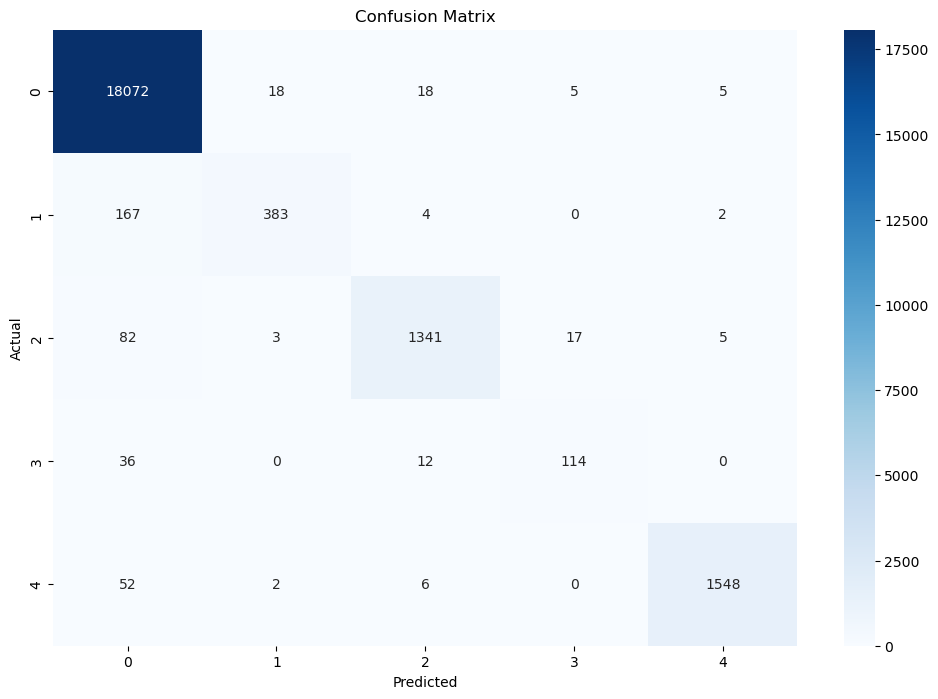

In [41]:
# make confusion matrix on test data for different classes
conf_matrix = confusion_matrix(lables_test, preds)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

